Imports Necesarios

In [62]:
from xml.etree import ElementTree as ET
from lib.chunckify import chunckify
from functools import reduce
import operator
import re
import os
from typing import Counter
import pandas as pd
from pandas import to_datetime
import matplotlib.pyplot as plt
import seaborn

Obtencion de rutas necesarias

In [4]:
# Ruta del directorio contenedor del atchivo actual
root_path = os.path.abspath('')

# Ruta del archivo posts.xml
posts_path = os.path.join(root_path, "dataset/Stack Overflow 11-2010/112010 Meta Stack Overflow/posts.xml")

# Ruta donde se guardaran los archivos
output_path = os.path.join(root_path, 'output')

# Lee el archivo posts.xml
tree = ET.parse(posts_path)
root = tree.getroot()

### Top 10 palabras más usadas por cada tipo de Post

Obtiene la id de cada post y cuenta las palabras que contiene

In [5]:
def palabras_por_postype(data):
    post_type = data.attrib['PostTypeId']
    body = data.attrib['Body']
    # Obtener todas las palabras del body en una lista
    body = re.findall('(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+(?=:(?!\S))', body)
    # Contar palabras
    words = Counter(body)
    return post_type, words

Crea un diccionario con el tipo de post como clave y el contador de palabras como valor

In [6]:
def separar_typeid(data,):
    return dict([[postid, data[1].copy()]for postid in data[0]])

A los tipo de post iguales, los une y actualiza los contadores de palabras

In [7]:
def reduce_by_id(data1, data2):
    for key,value in data2.items():
        if key in data1.keys():
            data1[key].update(data2[key])
        else:
            data1.update({key:value})
        return data1

Por cada chunk de datos, extrae los datos y los reduce

In [8]:
def mapper(data):
    words_count = list(map(palabras_por_postype, data))
    words_count = list(map(separar_typeid, words_count))

    reduced = reduce(reduce_by_id, words_count)
    return reduced

Obtiene el top 10 de palabras por tipo de post

In [9]:
def get_top(data):
    return data[0], data[1].most_common(10)

Obtiene un conjunto de datos. Lo fracciona y le aplica Map Reduce. Luego obtiene el top 10 de palabras por tipo de post.

In [40]:
data_chunks = chunckify(root,50)

mapped = list(map(mapper, data_chunks))
reduced_mapped = reduce(reduce_by_id, mapped)

top = dict(map(get_top, reduced_mapped.items()))

[('the', 19080),
 ('to', 13918),
 ('a', 10950),
 ('I', 8542),
 ('of', 7286),
 ('and', 7105),
 ('is', 6280),
 ('that', 5849),
 ('it', 4975),
 ('on', 4555)]

Con la extracción anterior, Crea una tabla y la guarda en un archivo csv

In [50]:
dataframe1 = pd.DataFrame(top.get('1'), columns=['Palabras', 'Cuenta'])
dataframe2 = pd.DataFrame(top.get('2'), columns=['Palabras', 'Cuenta'])
dataframe1.to_csv(f'{output_path}/top_palabras_en_post_type_1.csv', index=False)
dataframe2.to_csv(f'{output_path}/top_palabras_en_post_type_2.csv', index=False)

,Palabras,Cuenta
0,the,19080
1,to,13918
2,a,10950
3,I,8542
4,of,7286
5,and,7105
6,is,6280
7,that,5849
8,it,4975
9,on,4555


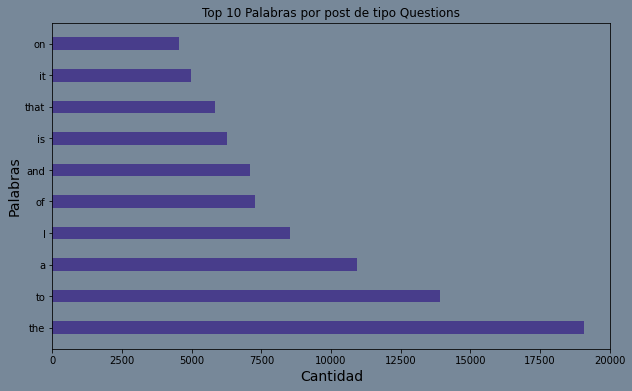

In [54]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='#778899')

posts= dataframe1.Palabras
visitas = dataframe1.Cuenta

ax.set_title('Top 10 Palabras por post de tipo Preguntas')
ax.barh(posts, visitas, height=0.4, color='#483D8B')
ax.set_facecolor('#778899')
ax.set_xlabel('Cantidad', fontsize=14)
ax.set_ylabel('Palabras', fontsize=14)
plt.show()

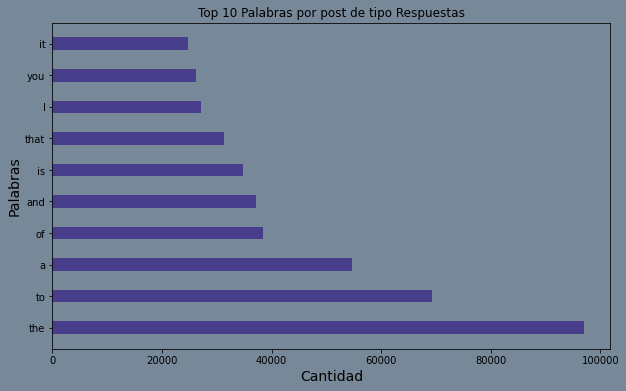

In [61]:
posts= dataframe2.Palabras
visitas = dataframe2.Cuenta

fig, ax = plt.subplots(figsize=(10,6), facecolor='#778899')

ax.set_title('Top 10 Palabras por post de tipo Respuestas')
ax.barh(posts, visitas, height=0.4, color='#483D8B')
ax.set_facecolor('#778899')
ax.set_xlabel('Cantidad', fontsize=14)
ax.set_ylabel('Palabras', fontsize=14)
plt.show()

### Top 10 posts menos vistos

Por cada post, extrae la cantidad de visitas

In [79]:
def least_viewed(data):
    # Id de cada post
    post_id = data.attrib['Id']
    # Cuenta de las vistas
    view_count = data.attrib['ViewCount']
    dictionary = {post_id: int(view_count)}
    return dictionary

Ignora los posts que no tengan visitas

In [80]:
def reduce_items(data1:dict,data2):
    for key, value in data2.items():
        if value != 0:
            data1.update(data2)
        elif 0 in data1.values():
            data1.popitem()
    return data1

Retorna el top 10 posts menos vistos como diccionario con la id de cada post como llave y sus visitas como valor

In [81]:
def top10_least_viewed(data):
    s = sorted(data.items(), key=operator.itemgetter(1), reverse=False)
    d = []
    for i in range(10):
        d.append(s[i])
        # d.update(dict(s[i]))
    return dict(d)

Define el proceso de extraccion y reduccion para cada chunk de datos

In [82]:
def mapper(data):
    post_viewd = list(map(least_viewed, data))
    reducing = reduce(reduce_items, post_viewd)
    return reducing

Obtiene un conjunto de datos, lo fracciona y le aplica el proceso correspondiente

In [83]:
data_chunks = chunckify(root,50)

mapped = list(map(mapper, data_chunks))
reduce_mapped = reduce(reduce_items, mapped)

top10 = top10_least_viewed(reduce_mapped)

Guarda el top 10 de los posts menos vistos en un archivo csv

In [84]:
df = pd.DataFrame(top10.items(), columns=['Posts', 'Visitas'])
df.to_csv(f'{output_path}/top_10_posts_menos_vistos.csv', index=False)
df

,Posts,Visitas
0,617,1
1,59881,5
2,58985,7
3,60468,7
4,20024,8
5,62483,8
6,66002,8
7,55746,9
8,62204,9
9,63096,9


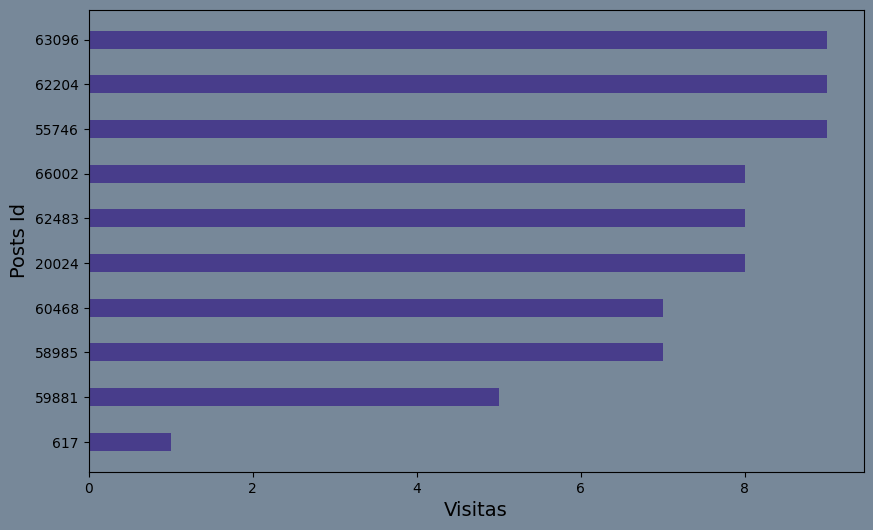

In [112]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='#778899')

posts= df.Posts
visitas = df.Visitas

ax.barh(posts, visitas, height=0.4, color='#483D8B')
ax.set_facecolor('#778899')
ax.set_xlabel('Visitas', fontsize=14)
ax.set_ylabel('Posts Id', fontsize=14)
plt.show()

<AxesSubplot:xlabel='Palabras', ylabel='Cuenta'>

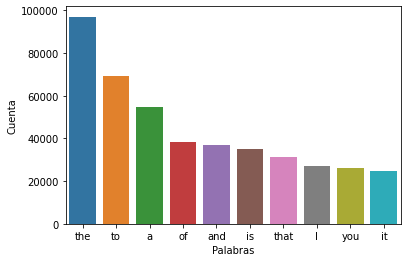

In [65]:
seaborn.barplot(x=posts, y=visitas)

### Del ranking de los primeros 300-400 por score, promedia la cantidad de tiempo que se tarda en realizar una respuesta aceptada

Extrae el Id, Score, CreationDate, y AcceptedAnswerId de cada post

In [32]:
def postdate_postid(data):
    post_id = data.attrib['Id']
    score = data.attrib['Score']
    creation_date = data.attrib['CreationDate']
    try:
        answer_id = data.attrib['AcceptedAnswerId']
    except:
        answer_id = None
    t = (int(score), answer_id, creation_date)
    d = {post_id: t}
    return d

Filtra todos los posts que no tengan AnswerId

In [33]:
def filtering_none_answer(data):
    for key, value in data.items():
        if data== None:
            pass
        return value[1] != None

Reduce, que ignora todos los posts que tengan un score igual a cero

In [34]:
def reduce_items(data1:dict,data2):
    if data2 != None:
        for key, value in data2.items():
            if value[0] != 0:
                data1.update(data2)
            elif 0 in data1.values():
                data1.popitem()
        return data1
    else:
        return data1

Para cada chunk de datos, le realiza las funciones de map reduce

In [35]:
def mapper(data):
    post_score = list(map(postdate_postid, data))
    filtering = list(filter(filtering_none_answer, post_score))
    if len(filtering) > 0:
        reduced = reduce(reduce_items, filtering)
        return reduced

Devuelve el top 400 de posts con mayor score

In [36]:
def top400_por_score(data):
    d = Counter(data)
    d = d.most_common(400)
    return dict(d)

Obtiene el tiempo promedio en el que se acepta una respuesta en stack overflow

In [37]:
def obtener_tiempo_promedio(top400):
    a = 0
    for key, value in top400.items():
        question_date = value[2]
        answer_row = root.findall(f".//row[@Id='{value[1]}']")
        answer_date = answer_row[0].attrib['CreationDate']
        a+=to_datetime(answer_date).to_numpy() - to_datetime(question_date).to_numpy()
    return int(((a/400)/10**9))/60

Extrae los datos del archivo posts, lo fracciona en varios conjuntos de datos y le aplica map reduce

In [39]:
tree = ET.parse(f'{posts_path}')
root = tree.getroot()
data_chunks = chunckify(root,50)
mapped = list(map(mapper, data_chunks))
reduced = reduce(reduce_items, mapped)
top400 = top400_por_score(reduced)
promedio = obtener_tiempo_promedio(top400)

In [43]:
print(promedio, 'minutos')

39972.78333333333 minutos


Analizando la relación entre la cantidad de palabras y cantidad de respuestas, podemos observar que realizar preguntas de más de 600 palabras no lograría que se incremente la cantidad de respuestas. En el rango entre 200 y 600 palabras es donde se observa la mayor cantidad de respuestas, esto podría suceder debido a que las preguntas más extensas podrían tener requerimientos más específicos o podrían ser más engorrosas de leer, generando que obtengan menos respuestas.  